In [319]:
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import OneHotEncoder
from patsy import dmatrices,dmatrix
from sklearn.metrics import roc_auc_score

In [212]:
df = pd.read_csv('final_proj_clean.csv')
df = df.drop(['Unnamed: 0'], axis = 1)
df = df.replace(True,1)
df = df.replace(False,0)
df['championPlayed'] = df['championPlayed'].astype('category')
df['firstBlood'] = df['firstBlood'].astype('category')
df['firstTower'] = df['firstTower'].astype('category')
df['firstInhibitor'] = df['firstInhibitor'].astype('category')
df['firstBaron'] = df['firstBaron'].astype('category')
df['firstDragon'] = df['firstDragon'].astype('category')
df['firstRiftHerald'] = df['firstRiftHerald'].astype('category')
df['playerId'] =df['playerId'].astype('category')



In [213]:
df

,winloss,playerId,championPlayed,kills,deaths,assists,goldEarned,inhibitorKills,turretKills,visionScore,...,totalDamageTaken,longestTimeSpentLiving,totalDamageDealtToChampions,totalTimeCrowdControlDealt,firstBlood,firstTower,firstInhibitor,firstBaron,firstDragon,firstRiftHerald
0,1,omKM0-rENPoC4ZDmjA-6oFSKysuXuyzET86KbCTtIFtFwQ,134,9,2,2,10401,0,1,5,...,10006,794,15861,145,1.0,1.0,0.0,0.0,1.0,1.0
1,0,omKM0-rENPoC4ZDmjA-6oFSKysuXuyzET86KbCTtIFtFwQ,134,7,10,11,12636,1,0,27,...,26612,486,31334,274,1.0,1.0,1.0,1.0,0.0,1.0
2,0,omKM0-rENPoC4ZDmjA-6oFSKysuXuyzET86KbCTtIFtFwQ,8,9,12,16,16815,0,4,25,...,51215,404,54000,172,1.0,1.0,1.0,1.0,1.0,1.0
3,0,omKM0-rENPoC4ZDmjA-6oFSKysuXuyzET86KbCTtIFtFwQ,110,2,4,3,9147,0,0,11,...,11614,442,8694,233,0.0,0.0,0.0,0.0,1.0,0.0
4,1,omKM0-rENPoC4ZDmjA-6oFSKysuXuyzET86KbCTtIFtFwQ,69,6,9,8,12246,0,0,32,...,24436,714,20481,171,1.0,1.0,1.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11314,1,Rii5E_AEdlpQMiPrpCpZZzTl2HAon783Wb2sARbN8I2DhT...,119,16,4,6,15622,0,4,13,...,14140,713,23960,87,0.0,1.0,1.0,1.0,1.0,1.0
11315,0,Rii5E_AEdlpQMiPrpCpZZzTl2HAon783Wb2sARbN8I2DhT...,29,4,6,4,8064,0,0,6,...,13346,338,10094,180,0.0,0.0,0.0,0.0,0.0,0.0
11316,0,Rii5E_AEdlpQMiPrpCpZZzTl2HAon783Wb2sARbN8I2DhT...,29,0,0,0,845,0,0,1,...,654,0,588,0,0.0,0.0,0.0,0.0,0.0,0.0
11317,1,Rii5E_AEdlpQMiPrpCpZZzTl2HAon783Wb2sARbN8I2DhT...,29,15,1,2,14202,0,2,17,...,8973,1184,24757,280,1.0,1.0,1.0,1.0,1.0,1.0


In [208]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11319 entries, 0 to 11318
Data columns (total 21 columns):
 #   Column                       Non-Null Count  Dtype   
---  ------                       --------------  -----   
 0   winloss                      11319 non-null  int64   
 1   playerId                     11319 non-null  category
 2   championPlayed               11319 non-null  category
 3   kills                        11319 non-null  int64   
 4   deaths                       11319 non-null  int64   
 5   assists                      11319 non-null  int64   
 6   goldEarned                   11319 non-null  int64   
 7   inhibitorKills               11319 non-null  int64   
 8   turretKills                  11319 non-null  int64   
 9   visionScore                  11319 non-null  int64   
 10  totalDamageDealt             11319 non-null  int64   
 11  totalDamageTaken             11319 non-null  int64   
 12  longestTimeSpentLiving       11319 non-null  int64   
 13  t

<AxesSubplot:>

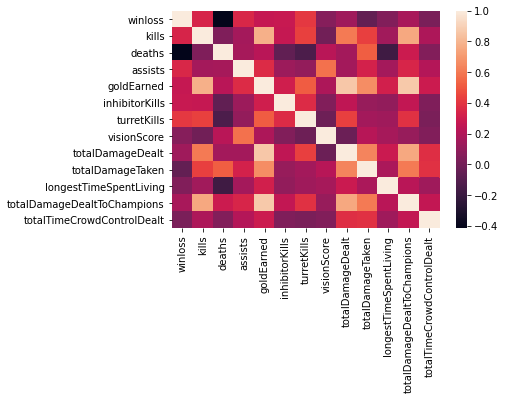

In [84]:
sns.heatmap(data=df.corr())

In [85]:
df.winloss.value_counts(normalize=True)

1    0.534588
0    0.465412
Name: winloss, dtype: float64

#### As recommended, I will fit models on a player by player basis

In [86]:
players_separated_list = [pd.DataFrame(y) for x, y in df.groupby('playerId', as_index=False)]

In [307]:
simple_summary_dictionary = {}
simple_classification_dictionary = {}

interactions_summary_dictionary = {}
interactions_classification_dictionary = {}

three_summary_dictionary = {}
three_classification_dictionary = {}

CVsimple_summary_dictionary = {}
CVsimple_classification_dictionary = {}
CVcoefficients = {}

auc_scores = {}
pipeline_summary_dictionary = {}
pipeline_score_dictionary = {}

In [308]:


simple_additive = 'winloss ~ C(championPlayed) + kills + deaths + assists + goldEarned + inhibitorKills + turretKills + visionScore' \
                  '+ totalDamageDealt + totalDamageTaken + longestTimeSpentLiving + totalDamageDealtToChampions + totalTimeCrowdControlDealt' \
                  '+ C(firstBlood) + C(firstTower) + C(firstInhibitor) + C(firstBaron) + C(firstDragon) + C(firstRiftHerald)'

simple_interact = 'winloss ~ (C(championPlayed) + kills + deaths + assists + goldEarned + inhibitorKills + turretKills + visionScore' \
                  '+ totalDamageDealt + totalDamageTaken + longestTimeSpentLiving + totalDamageDealtToChampions + totalTimeCrowdControlDealt' \
                  '+ C(firstBlood) + C(firstTower) + C(firstInhibitor) + C(firstBaron) + C(firstDragon) + C(firstRiftHerald))**2 '

#taking log of applicable variables because variables seem to be related in many ways
three_interact =  'winloss ~ (C(championPlayed) + kills + deaths + assists + goldEarned + inhibitorKills + turretKills + visionScore' \
                  '+ totalDamageDealt + totalDamageTaken + longestTimeSpentLiving + totalDamageDealtToChampions + totalTimeCrowdControlDealt' \
                  '+ C(firstBlood) + C(firstTower) + C(firstInhibitor) + C(firstBaron) + C(firstDragon) + C(firstRiftHerald))**3'

columns_to_standardize = ['kills','deaths','assists','goldEarned','inhibitorKills','turretKills','visionScore','totalDamageDealt',
               'totalDamageTaken','longestTimeSpentLiving','totalDamageDealtToChampions','totalTimeCrowdControlDealt']

C_list = np.exp(np.linspace(-6, 6, num=11))

def SimpleModelFit(instance, player_data, formula_used, summary_dict, class_dict, num_cols):
    #set up to standardize (I have to or else the fitting fails to converge)
    temp_player_data = player_data.sample(frac=1).copy()
    standard = StandardScaler()
    temp_player_data[num_cols] = standard.fit_transform(temp_player_data[num_cols])
    
    y_temp, X_temp = dmatrices(formula_used+' -1', temp_player_data)
    temp_fit = LogisticRegression(max_iter=10000,fit_intercept=False).fit(X_temp[125:],y_temp[125:].ravel())
    #add summary to a dictionary
    summary_dict['player_'+str(instance)] = temp_fit.score(X_temp[:125],y_temp[:125].ravel())

    temp_player_data['pred_prob'] = temp_fit.predict_proba(X_temp).tolist()
    temp_player_data['pred_class'] = temp_fit.predict(X_temp).tolist()
    
    
    #add the dataframe with probabilities and classification to dictionary
    class_dict['player'+str(instance)] = temp_player_data

    
    

#this function is like SimpleModelFit, but uses CV too
def SimpleCVFit(instance, player_data, formula_used, summary_dict, class_dict, num_cols):
    #set up to standardize (I have to or else the fitting fails to converge)
    temp_player_data = player_data.sample(frac=1).copy()
    standard = StandardScaler()
    temp_player_data[num_cols] = standard.fit_transform(temp_player_data[num_cols])
    
    y_temp, X_temp = dmatrices(formula_used+' -1', temp_player_data)
    temp_fit = LogisticRegressionCV(Cs=C_list ,l1_ratios=[0.0,0.5,1.0],solver='saga',penalty='elasticnet',random_state=101,cv=5, max_iter=10000, fit_intercept=False,n_jobs=-1).fit(X_temp,y_temp.ravel())
    
    #add summary to a dictionary
    summary_dict['player_'+str(instance)] = temp_fit.score(X_temp,y_temp.ravel())

    temp_player_data['pred_prob'] = temp_fit.predict_proba(X_temp).tolist()
    temp_player_data['pred_class'] = temp_fit.predict(X_temp).tolist()
    
    #add the dataframe with probabilities and classification to dictionary
    class_dict['player_'+str(instance)] = temp_player_data
    CVcoefficients['player_'+str(instance)] = temp_fit.coef_
    print('player_'+str(instance)+' best fit l1 ratio = '+str(temp_fit.l1_ratio_))
    auc_scores['player_'+str(instance)] = roc_auc_score(y_temp, temp_fit.predict_proba(X_temp)[:, 1])
      

        
#this function will handle the fitting, etc.for more complex models
def PipelineModelTuning(instance, player_data, cv_params, summary_dict, class_dict):
    w = 0


**I forgot to lump! ooops! thats why it took so long!**

In [309]:
tracker = 1
#for every player's subset of data in the list
for different_player in players_separated_list:
    #need to lump
    series = pd.value_counts(different_player.championPlayed)
    mask = (series/series.sum() * 100).lt(10)
    different_player['championPlayed'] = np.where(different_player['championPlayed'].isin(series[mask].index),'Other',different_player['championPlayed'])
    different_player['championPlayed'] = different_player['championPlayed'].astype('category')
    
    #simple model stuff
    SimpleModelFit(tracker,different_player,simple_additive,simple_summary_dictionary,simple_classification_dictionary,columns_to_standardize)
    
    #trying out interacting pair features
    SimpleModelFit(tracker,different_player,simple_interact,interactions_summary_dictionary,interactions_classification_dictionary,columns_to_standardize)
    
    #trying out CV on a more complex model
    SimpleCVFit(tracker,different_player,simple_interact,CVsimple_summary_dictionary,CVsimple_classification_dictionary,columns_to_standardize)
    
    
    #trying out the log transformation
    #SimpleModelFit(tracker,different_player,three_interact,three_summary_dictionary,three_classification_dictionary,columns_to_standardize)
    
    #do DataPipeline (for each fold: standardize, PCA?, polynomialFeatures, fit_model/potentially penalize)
    #store summaries
    #store scores
    tracker = tracker + 1

player_1 best fit l1 ratio = [1.]
player_2 best fit l1 ratio = [1.]
player_3 best fit l1 ratio = [0.]
player_4 best fit l1 ratio = [0.5]
player_5 best fit l1 ratio = [1.]
player_6 best fit l1 ratio = [1.]
player_7 best fit l1 ratio = [0.5]
player_8 best fit l1 ratio = [0.5]
player_9 best fit l1 ratio = [0.]
player_10 best fit l1 ratio = [1.]
player_11 best fit l1 ratio = [0.5]
player_12 best fit l1 ratio = [0.]
player_13 best fit l1 ratio = [0.]
player_14 best fit l1 ratio = [0.]
player_15 best fit l1 ratio = [0.5]
player_16 best fit l1 ratio = [1.]
player_17 best fit l1 ratio = [0.5]
player_18 best fit l1 ratio = [0.]
player_19 best fit l1 ratio = [0.5]
player_20 best fit l1 ratio = [0.]
player_21 best fit l1 ratio = [1.]
player_22 best fit l1 ratio = [0.]
player_23 best fit l1 ratio = [0.]
player_24 best fit l1 ratio = [0.]
player_25 best fit l1 ratio = [0.]


**The elastic net l1_ratio changes for each player**

Number of Lasso: 8     
Number of Ridge: 7     
Number of Mixed: 10    

**A mix of L1 and L2 penalization seems to be the most popular. Some features are probably irrelevant.**


In [293]:
simple_summary_dictionary

{'player_1': 0.96,
 'player_2': 0.944,
 'player_3': 0.96,
 'player_4': 0.96,
 'player_5': 0.856,
 'player_6': 0.88,
 'player_7': 0.928,
 'player_8': 0.92,
 'player_9': 0.936,
 'player_10': 0.808,
 'player_11': 0.968,
 'player_12': 0.888,
 'player_13': 0.904,
 'player_14': 0.92,
 'player_15': 0.872,
 'player_16': 0.928,
 'player_17': 0.936,
 'player_18': 0.96,
 'player_19': 0.904,
 'player_20': 0.896,
 'player_21': 0.912,
 'player_22': 0.928,
 'player_23': 0.904,
 'player_24': 0.944,
 'player_25': 0.904}

In [294]:
interactions_summary_dictionary

{'player_1': 0.92,
 'player_2': 0.92,
 'player_3': 0.928,
 'player_4': 0.92,
 'player_5': 0.904,
 'player_6': 0.832,
 'player_7': 0.888,
 'player_8': 0.92,
 'player_9': 0.912,
 'player_10': 0.856,
 'player_11': 0.896,
 'player_12': 0.848,
 'player_13': 0.936,
 'player_14': 0.888,
 'player_15': 0.84,
 'player_16': 0.888,
 'player_17': 0.864,
 'player_18': 0.96,
 'player_19': 0.904,
 'player_20': 0.864,
 'player_21': 0.912,
 'player_22': 0.888,
 'player_23': 0.904,
 'player_24': 0.904,
 'player_25': 0.84}

In [295]:
CVsimple_summary_dictionary

{'player_1': 0.96,
 'player_2': 0.984,
 'player_3': 0.966,
 'player_4': 1.0,
 'player_5': 0.95,
 'player_6': 0.9611650485436893,
 'player_7': 0.932,
 'player_8': 0.95,
 'player_9': 0.9697986577181208,
 'player_10': 0.9602649006622517,
 'player_11': 0.946,
 'player_12': 0.9230769230769231,
 'player_13': 0.972,
 'player_14': 0.996,
 'player_15': 0.934,
 'player_16': 0.936,
 'player_17': 0.95,
 'player_18': 0.974,
 'player_19': 0.9659863945578231,
 'player_20': 0.9921875,
 'player_21': 0.986,
 'player_22': 0.998,
 'player_23': 0.948,
 'player_24': 0.962,
 'player_25': 0.946}

In [360]:
auc_scores

{'player_1': 0.9924948240165632,
 'player_2': 0.9991974833076528,
 'player_3': 0.9919838717419479,
 'player_4': 1.0,
 'player_5': 0.989312184758105,
 'player_6': 0.9981268624946785,
 'player_7': 0.9865582288489778,
 'player_8': 0.9904244306418221,
 'player_9': 0.9999542124542125,
 'player_10': 0.9948090470893585,
 'player_11': 0.9828181453231635,
 'player_12': 0.9962053571428571,
 'player_13': 0.993328928922477,
 'player_14': 0.993739091447695,
 'player_15': 0.9795652173913043,
 'player_16': 0.9914288918438297,
 'player_17': 0.9912411330483099,
 'player_18': 0.9996767676767677,
 'player_19': 0.9825426944971537,
 'player_20': 1.0,
 'player_21': 0.9899513568868408,
 'player_22': 0.9995458894889635,
 'player_23': 0.9918265756724207,
 'player_24': 0.9962084386544818,
 'player_25': 0.9838854648176683}

In [368]:
d1 =  dmatrix(simple_interactx+'-1', players_separated_list[0][columns_to_np])
d2 =  dmatrix(simple_interactx+'-1', players_separated_list[1][columns_to_np])
d24 =  dmatrix(simple_interactx+'-1', players_separated_list[23][columns_to_np])


In [325]:
coef_list = []
for v in CVcoefficients.values():
    coef_list.append(v[0])
    

In [326]:
coef_frame = pd.DataFrame(coef_list,index=CVcoefficients.keys())

In [327]:
coef_frame['l1_ratio'] = [0,1,0,1,1,0,1,1,1,1,0,0,0.5,0.5,1,0.5,0.5,0.5,1,1,1,1,1,0.5,0.5]

##### Player 1 Curated Coefficients

In [359]:
player_1_frame =  coef_frame.iloc[:1, : 229]
player_1_frame.columns = d1.design_info.column_names
player_1_frame[columns_to_np_df]


,kills,deaths,assists,goldEarned,inhibitorKills,turretKills,visionScore,totalDamageDealt,totalDamageTaken,longestTimeSpentLiving,totalDamageDealtToChampions,totalTimeCrowdControlDealt
player_1,0.469215,-1.678355,1.204664,0.0,0.547321,1.135849,0.0,0.0,0.0,-0.661215,0.0,0.0


##### Player 1 Curated Boolean Coefficients 

In [373]:
player_1_frame.iloc[:,1:15]

,C(championPlayed)[51],C(championPlayed)[67],C(championPlayed)[Other],C(firstBlood)[T.1.0],C(firstTower)[T.1.0],C(firstInhibitor)[T.1.0],C(firstBaron)[T.1.0],C(firstDragon)[T.1.0],C(firstRiftHerald)[T.1.0],C(championPlayed)[T.51]:C(firstBlood)[T.1.0],C(championPlayed)[T.67]:C(firstBlood)[T.1.0],C(championPlayed)[T.Other]:C(firstBlood)[T.1.0],C(championPlayed)[T.51]:C(firstTower)[T.1.0],C(championPlayed)[T.67]:C(firstTower)[T.1.0]
player_1,0.0,0.0,-0.07474,0.0,1.104616,1.10885,0.847186,0.0,0.0,0.0,0.0,0.0,0.0,0.0


##### Player 2 Curated Coefficients

In [366]:
player_2_frame =  coef_frame.iloc[1:2, : 191]
player_2_frame.columns = d2.design_info.column_names
player_2_frame[columns_to_np_df]

,kills,deaths,assists,goldEarned,inhibitorKills,turretKills,visionScore,totalDamageDealt,totalDamageTaken,longestTimeSpentLiving,totalDamageDealtToChampions,totalTimeCrowdControlDealt
player_2,0.600535,-1.987631,1.342321,0.0,0.028227,1.441961,0.0,0.0,0.0,-0.852287,0.326084,0.0


##### Player 2 Curated Boolean Coefficients

In [374]:
player_2_frame.iloc[:,1:15]

,C(championPlayed)[Other],C(firstBlood)[T.1.0],C(firstTower)[T.1.0],C(firstInhibitor)[T.1.0],C(firstBaron)[T.1.0],C(firstDragon)[T.1.0],C(firstRiftHerald)[T.1.0],C(championPlayed)[T.Other]:C(firstBlood)[T.1.0],C(championPlayed)[T.Other]:C(firstTower)[T.1.0],C(championPlayed)[T.Other]:C(firstInhibitor)[T.1.0],C(championPlayed)[T.Other]:C(firstBaron)[T.1.0],C(championPlayed)[T.Other]:C(firstDragon)[T.1.0],C(championPlayed)[T.Other]:C(firstRiftHerald)[T.1.0],C(firstBlood)[T.1.0]:C(firstTower)[T.1.0]
player_2,-1.483189,0.0,0.439075,3.365255,1.851985,0.584922,0.0,0.0,0.387641,0.0,0.939646,0.0,-0.013051,0.0


##### Player 24 Curated Coefficients

In [376]:
player_24_frame =  coef_frame.iloc[23:24, : 248]
player_24_frame.columns = d24.design_info.column_names
player_24_frame[columns_to_np_df]

,kills,deaths,assists,goldEarned,inhibitorKills,turretKills,visionScore,totalDamageDealt,totalDamageTaken,longestTimeSpentLiving,totalDamageDealtToChampions,totalTimeCrowdControlDealt
player_24,0.400676,-0.739289,0.639375,0.0778,0.210041,0.462888,0.076944,-0.036958,-0.134699,-0.221478,0.07876,0.033857


##### Player 24 Curated Boolean Coefficients

In [377]:
player_24_frame.iloc[:,1:15]

,C(championPlayed)[147],C(championPlayed)[37],C(championPlayed)[99],C(championPlayed)[Other],C(firstBlood)[T.1.0],C(firstTower)[T.1.0],C(firstInhibitor)[T.1.0],C(firstBaron)[T.1.0],C(firstDragon)[T.1.0],C(firstRiftHerald)[T.1.0],C(championPlayed)[T.147]:C(firstBlood)[T.1.0],C(championPlayed)[T.37]:C(firstBlood)[T.1.0],C(championPlayed)[T.99]:C(firstBlood)[T.1.0],C(championPlayed)[T.Other]:C(firstBlood)[T.1.0]
player_24,-0.116158,-0.010012,-0.181393,-0.204469,-0.141471,0.233733,0.720597,0.370319,0.132986,-0.049551,-0.04379,0.071568,-0.020201,-0.088406


#### Examining Distribution of Winrate for each player

In [317]:
for pl in players_separated_list:
    print(pl.winloss.value_counts(normalize=True))

1    0.552
0    0.448
Name: winloss, dtype: float64
1    0.528
0    0.472
Name: winloss, dtype: float64
1    0.502
0    0.498
Name: winloss, dtype: float64
1    0.52
0    0.48
Name: winloss, dtype: float64
1    0.558
0    0.442
Name: winloss, dtype: float64
1    0.563107
0    0.436893
Name: winloss, dtype: float64
1    0.546
0    0.454
Name: winloss, dtype: float64
1    0.552
0    0.448
Name: winloss, dtype: float64
1    0.563758
0    0.436242
Name: winloss, dtype: float64
0    0.615894
1    0.384106
Name: winloss, dtype: float64
1    0.53
0    0.47
Name: winloss, dtype: float64
1    0.615385
0    0.384615
Name: winloss, dtype: float64
1    0.542
0    0.458
Name: winloss, dtype: float64
1    0.514
0    0.486
Name: winloss, dtype: float64
0    0.54
1    0.46
Name: winloss, dtype: float64
1    0.518
0    0.482
Name: winloss, dtype: float64
1    0.514
0    0.486
Name: winloss, dtype: float64
1    0.55
0    0.45
Name: winloss, dtype: float64
1    0.578231
0    0.421769
Name: winloss, dtype

In [358]:
columns_to_np_df = ['kills','deaths','assists','goldEarned','inhibitorKills','turretKills','visionScore','totalDamageDealt',
               'totalDamageTaken','longestTimeSpentLiving','totalDamageDealtToChampions','totalTimeCrowdControlDealt']

simple_interactx = '(C(championPlayed) + kills + deaths + assists + goldEarned + inhibitorKills + turretKills + visionScore' \
                  '+ totalDamageDealt + totalDamageTaken + longestTimeSpentLiving + totalDamageDealtToChampions + totalTimeCrowdControlDealt' \
                  '+ C(firstBlood) + C(firstTower) + C(firstInhibitor) + C(firstBaron) + C(firstDragon) + C(firstRiftHerald))**2 '

In [367]:
dmatrix(simple_interactx+'-1', players_separated_list[23][columns_to_np])

DesignMatrix with shape (500, 248)
  Columns:
    ['C(championPlayed)[142]',
     'C(championPlayed)[147]',
     'C(championPlayed)[37]',
     'C(championPlayed)[99]',
     'C(championPlayed)[Other]',
     'C(firstBlood)[T.1.0]',
     'C(firstTower)[T.1.0]',
     'C(firstInhibitor)[T.1.0]',
     'C(firstBaron)[T.1.0]',
     'C(firstDragon)[T.1.0]',
     'C(firstRiftHerald)[T.1.0]',
     'C(championPlayed)[T.147]:C(firstBlood)[T.1.0]',
     'C(championPlayed)[T.37]:C(firstBlood)[T.1.0]',
     'C(championPlayed)[T.99]:C(firstBlood)[T.1.0]',
     'C(championPlayed)[T.Other]:C(firstBlood)[T.1.0]',
     'C(championPlayed)[T.147]:C(firstTower)[T.1.0]',
     'C(championPlayed)[T.37]:C(firstTower)[T.1.0]',
     'C(championPlayed)[T.99]:C(firstTower)[T.1.0]',
     'C(championPlayed)[T.Other]:C(firstTower)[T.1.0]',
     'C(championPlayed)[T.147]:C(firstInhibitor)[T.1.0]',
     'C(championPlayed)[T.37]:C(firstInhibitor)[T.1.0]',
     'C(championPlayed)[T.99]:C(firstInhibitor)[T.1.0]',
     'C(cha